In [25]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
#Load original data which from cleaned_data folder on OSF
full_data = pd.read_csv('https://raw.githubusercontent.com/thimaipham/Data/main/morg-2014-emp.csv', 
                        dtype={16: str})

In [4]:
#Check data infomation
full_data.head(2)

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.0,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.0,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent


In [5]:
# Filter the dataset for the occupation 
# "Lawyers, Judges, magistrates, and other judicial workers" (occupation code 2100)
occupation_code = 2100
data = full_data[full_data['occ2012'] == occupation_code]

# Count the number of observations for this occupation
data.shape[0]

1027

###### This filter data include 1027 observations

### Feture Engineering

In [28]:
# Checking for missing values
missing_values = data.isnull().sum()

# Examining data types
data_types = data.dtypes

# Creating a new column for earnings per hour
data['earnings_per_hour'] = data['earnwke'] / data['uhours']

# Display the results
print(missing_values, data_types) 
print(data[['earnwke', 'uhours', 'earnings_per_hour']].head())


Unnamed: 0             0
hhid                   0
intmonth               0
stfips                 0
weight                 0
earnwke                0
uhours                 0
grade92                0
race                   0
ethnic               981
age                    0
sex                    0
marital                0
ownchild               0
chldpres               0
prcitshp               0
state                  0
ind02                  0
occ2012                0
class                  0
unionmme               0
unioncov              57
lfsr94                 0
earnings_per_hour      0
dtype: int64 Unnamed: 0             int64
hhid                   int64
intmonth              object
stfips                object
weight               float64
earnwke              float64
uhours                 int64
grade92                int64
race                   int64
ethnic               float64
age                    int64
sex                    int64
marital                int64
ownchild  

##### Missing values:
- The `ethnic` column has 981 missing values.
- The `unioncov` column has 57 missing values.
Due to a huge number of missing values in `ethic` column and some missing values in `unioncov` column, I will not choose them in the models of the following steps.  Because we have many other variable options for the models.

##### New column: 
- The column `earnings_per_hour` is created by `earnwke`/`uhours`. This will be the target variable for predictive modeling.

### Dealing with categorical values
- As I observed 'race', 'sex', 'marital', 'grade92' are categorical values. I searches for few days on the Internet on "How to deal with categorical values?" and OneHotEncoding method is recommended to convert categorical variables like 'race', 'sex', 'marital', and 'grade92' into a numerical format. This approach avoids imposing any artificial numerical order on these categories, which could lead to biased results. OneHotEncoding creates separate binary columns for each category, ensuring a more accurate representation in the model.

In [15]:
# Selecting categorical columns for one-hot encoding
categorical_columns = ['race', 'sex', 'marital', 'grade92']

# Initializing OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fitting and transforming the categorical columns
encoded_categorical = encoder.fit_transform(data[categorical_columns])

# Creating a DataFrame from the encoded categorical data
encoded_categorical_df = pd.DataFrame(encoded_categorical, 
                                      columns=encoder.get_feature_names_out(categorical_columns))

# Dropping original categorical columns from the data
data_transformed = data.drop(categorical_columns, axis=1)

# Merging the original data with the new encoded categorical columns
data_transformed = pd.concat([data_transformed, encoded_categorical_df], axis=1)

# Displaying the first few rows of the transformed data
data_transformed.head().T


,23,295,659,764,901
Unnamed: 0,45.0,656.0,1489.0,1729.0,1996.0
hhid,960021970039060.0,235004820400137.0,97977400095618.0,435002800600122.0,700609983456587.0
intmonth,January,January,January,January,January
stfips,AL,AZ,CA,CA,CA
weight,3811.7857,3434.7076,3166.3863,3060.5871,3057.3628
earnwke,1442.3,1384.61,2307.0,700.0,2884.61
uhours,50.0,40.0,50.0,50.0,50.0
ethnic,NaN,NaN,NaN,NaN,NaN
age,57.0,62.0,47.0,29.0,55.0
ownchild,0.0,0.0,1.0,0.0,0.0


In [32]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the data for label encoding
data_label_encoded = data.copy()

# Apply Label Encoding to each categorical column
label_encoders = {}
for column in categorical_columns:
    # Initialize a LabelEncoder for each column
    label_encoders[column] = LabelEncoder()
    # Transform and replace the column in the dataset
    data_label_encoded[column] = label_encoders[column].fit_transform(data[column])

# Check the data after applying Label Encoding
data_label_encoded.head()


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,earnings_per_hour
23,45,960021970039060,January,AL,3811.7857,1442.30,50,8,0,NaN,...,0,"Native, Born In US",63,Legal services (5411),2100,"Private, For Profit",No,No,Employed-At Work,28.84600
295,656,235004820400137,January,AZ,3434.7076,1384.61,40,7,0,NaN,...,0,"Native, Born In US",86,"Justice, public order, and safety activities (...",2100,Government - Federal,No,No,Employed-At Work,34.61525
659,1489,97977400095618,January,CA,3166.3863,2307.00,50,9,0,NaN,...,4,"Native, Born In US",93,Legal services (5411),2100,"Private, For Profit",No,No,Employed-At Work,46.14000
764,1729,435002800600122,January,CA,3060.5871,700.00,50,8,0,NaN,...,0,"Native, Born In US",93,"Accounting, tax preparation, bookkeeping, and ...",2100,"Private, For Profit",No,No,Employed-At Work,14.00000
901,1996,700609983456587,January,CA,3057.3628,2884.61,50,9,0,NaN,...,0,"Native, Born In US",93,Investigation and security services (5616),2100,"Private, For Profit",No,No,Employed-At Work,57.69220


#### Create Heatmap to see the correlation among variables

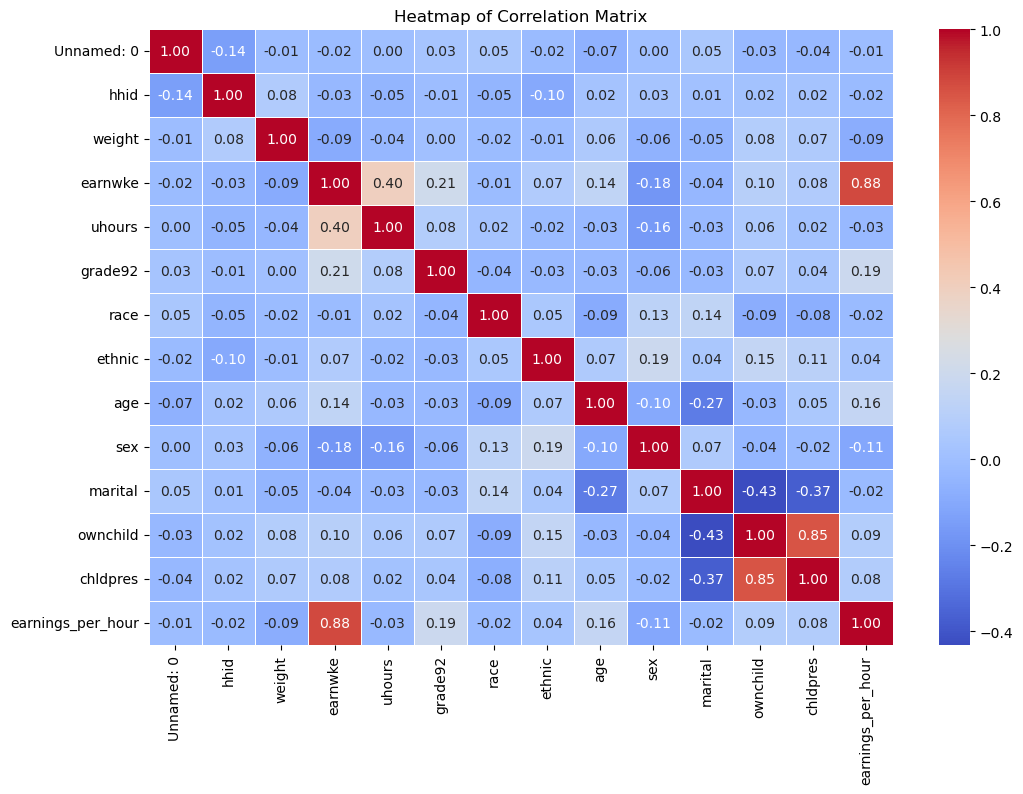

In [20]:
# Drop occupation column
data_without_occ2012 = data.drop('occ2012', axis=1)

# Correlation matrix
correlation_matrix_without_occ2012 = data_without_occ2012.corr()

# Create a heatmap matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_without_occ2012, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


- An observation of the correlation heatmap indicates that variables such as `age`,`grade92`  and `sex` might be significant predictors for 'earnings_per_hour' due to their relatively correlation coefficients.

## Choosing & Building Models

##### Split data into 2 part: training part and testing part

In [24]:
# Define predictors and target variable
X = data_transformed.drop(['earnings_per_hour'], axis=1)
y = data_transformed['earnings_per_hour']

# Split data into 2 parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the data part size
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1638, 44), (410, 44), (1638,), (410,))

### Model 1: The most simple model with predictor `age`

In [31]:
# Kiểm tra giá trị NaN trong cột 'age' của dữ liệu gốc
original_missing_values_age = data['age'].isnull().sum()
print("Missing values in 'age' in original data:", original_missing_values_age)

# Kiểm tra giá trị NaN sau khi biến đổi
transformed_missing_values_age = data_transformed['age'].isnull().sum()
print("Missing values in 'age' in transformed data:", transformed_missing_values_age)


Missing values in 'age' in original data: 0
Missing values in 'age' in transformed data: 1021
